In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM


Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

(828, 10)
(828,)


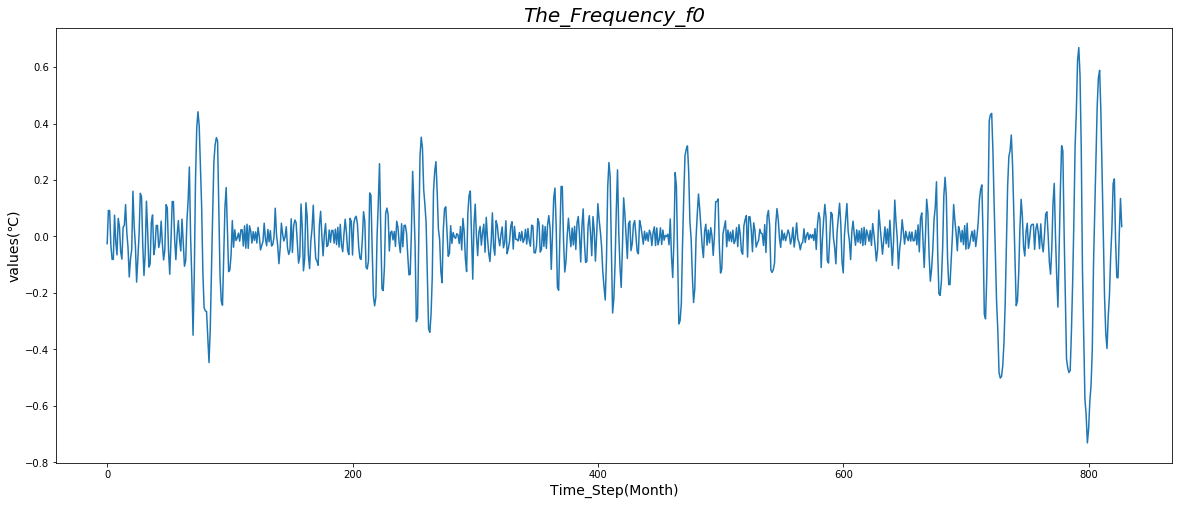

[[[-0.28373  ]
  [-0.20753  ]
  [-0.069358 ]
  [ 0.029479 ]
  [ 0.18765  ]
  [ 0.20383  ]
  [-0.017003 ]
  [-0.14515  ]
  [-0.14641  ]
  [ 0.0092768]
  [ 0.1346   ]
  [ 0.035037 ]]]
[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
(792, 24, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 11s - loss: 0.0219
Epoch 2/200
 - 2s - loss: 0.0217
Epoch 3/200
 - 2s - loss: 0.0210
Epoch 4/200
 - 2s - loss: 0.0196
Epoch 5/200
 - 2s - loss: 0.0200
Epoch 6/200
 - 2s - loss: 0.0176
Epoch 7/200
 - 2s - loss: 0.0171
Epoch 8/200
 - 2s - loss: 0.0164
Epoch 9/200
 - 2s - loss: 0.0159
Epoch 10/200
 - 2s - loss: 0.0153
Epoch 11/200
 - 2s - loss: 0.0145
Epoch 12/200
 - 2s - loss: 0.0142
Epoch 13/200
 - 2s - loss: 0.0136
Epoch 14/200
 - 2s - loss: 0.0136
Epoch 15/200
 - 2s - loss: 0.0143
Epoch 16/200
 - 2s - loss: 0.0131
Epoch 17/200
 - 

(67, 12)
(840,)


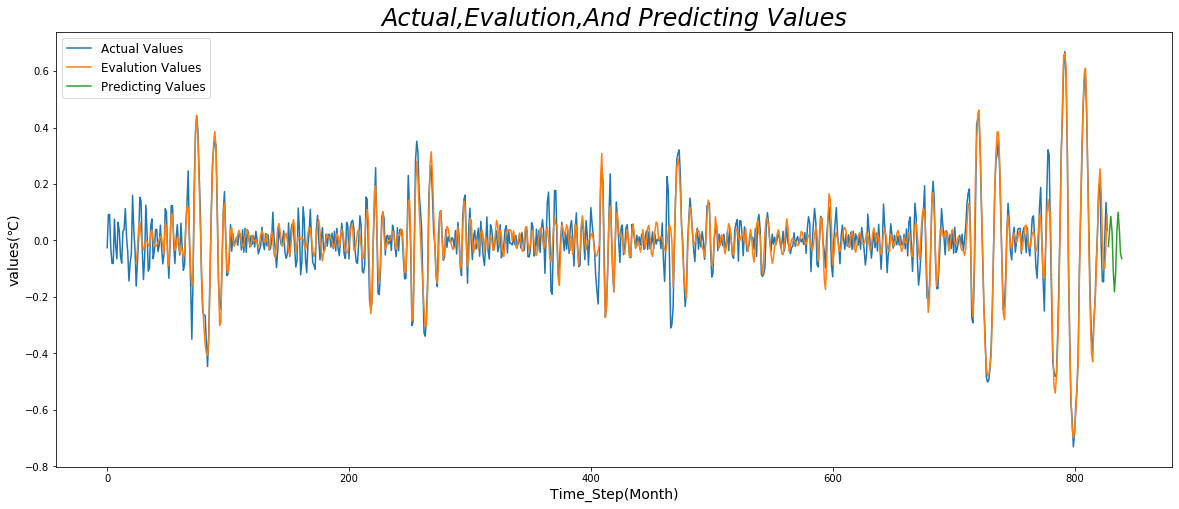

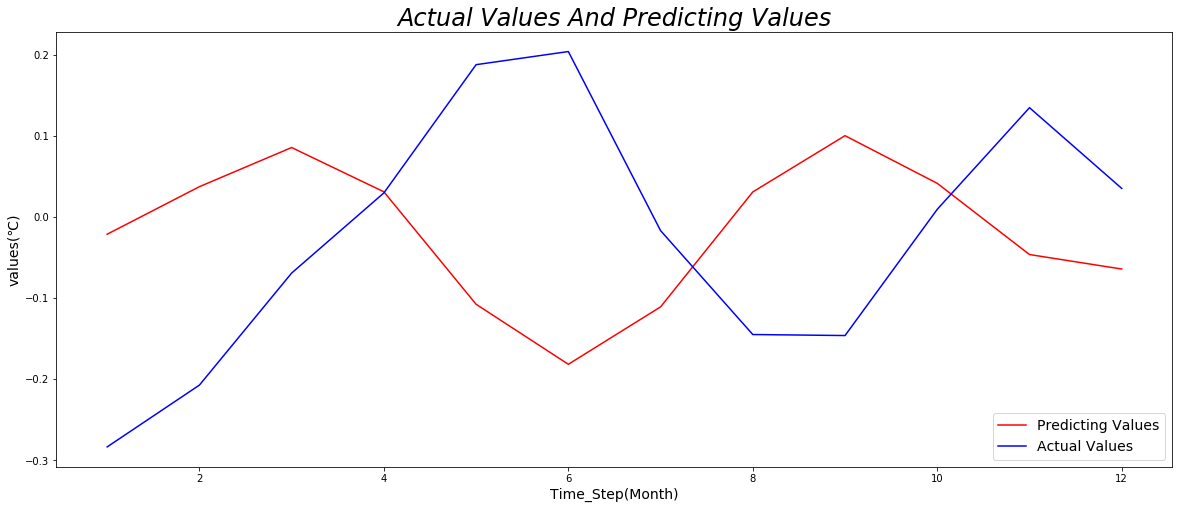

(828,)


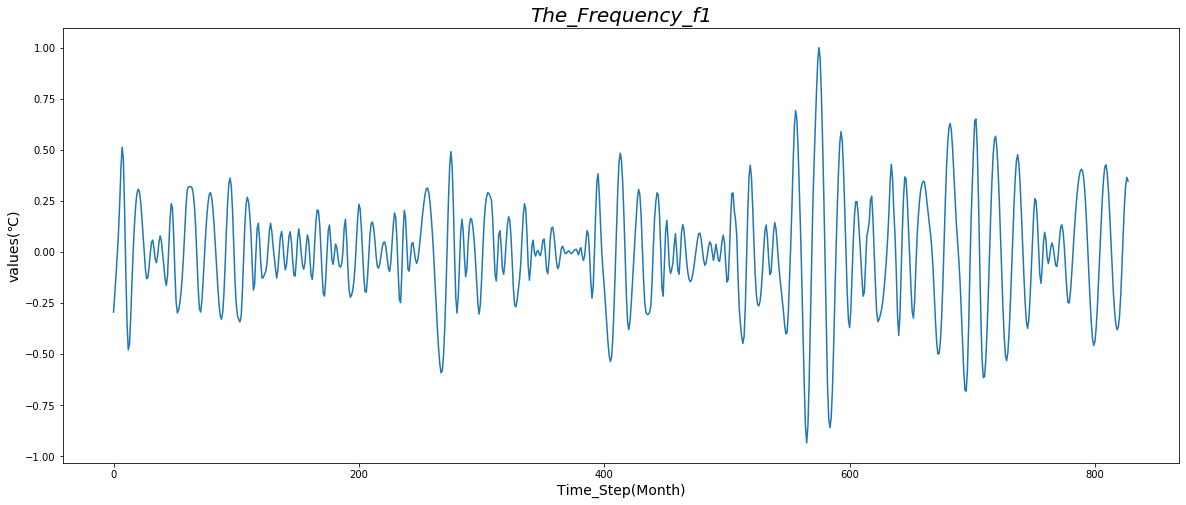

[[[-0.29143 ]
  [-0.354   ]
  [-0.38141 ]
  [-0.36968 ]
  [-0.31534 ]
  [-0.21508 ]
  [-0.071875]
  [ 0.086582]
  [ 0.22809 ]
  [ 0.32458 ]
  [ 0.36537 ]
  [ 0.34646 ]]]
[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
(792, 24, 1)
Epoch 1/200
 - 5s - loss: 0.0647
Epoch 2/200
 - 2s - loss: 0.0551
Epoch 3/200
 - 2s - loss: 0.0465
Epoch 4/200
 - 2s - loss: 0.0415
Epoch 5/200
 - 2s - loss: 0.0403
Epoch 6/200
 - 2s - loss: 0.0405
Epoch 7/200
 - 2s - loss: 0.0354
Epoch 8/200
 - 2s - loss: 0.0346
Epoch 9/200
 - 2s - loss: 0.0307
Epoch 10/200
 - 2s - loss: 0.0303
Epoch 11/200
 - 2s - loss: 0.0288
Epoch 12/200
 - 2s - loss: 0.0279
Epoch 13/200
 - 2s - loss: 0.0275
Epoch 14/200
 - 2s - loss: 0.0274
Epoch 15/200
 - 2s - loss: 0.0280
Epoch 16/200
 - 2s - loss: 0.0277
Epoch 17/200
 - 2s - loss: 0.0263
Epoch 18/200
 - 2s - loss: 0.0255
Epoch 19/200
 - 2s - loss: 0.0264
Epoch 20/200
 - 2s - loss: 0.0258
Epoch 21/200
 - 2s - lo

(67, 12)
(840,)


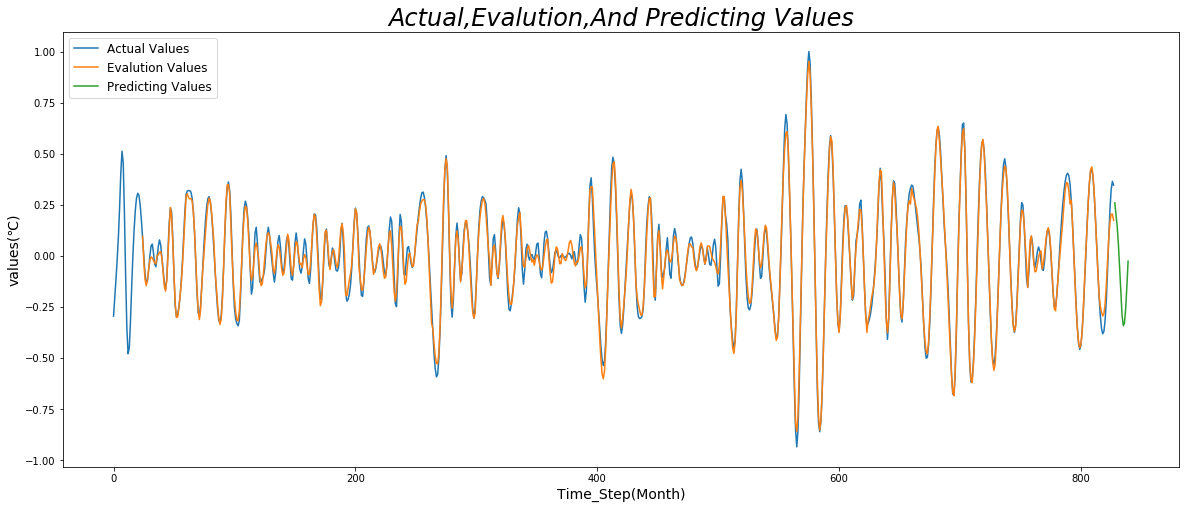

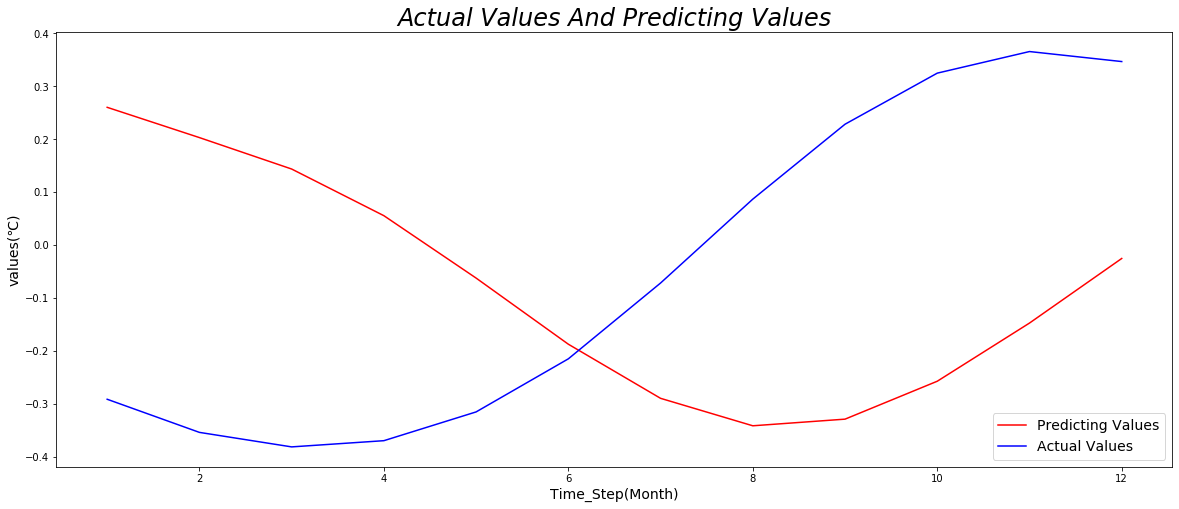

(828,)


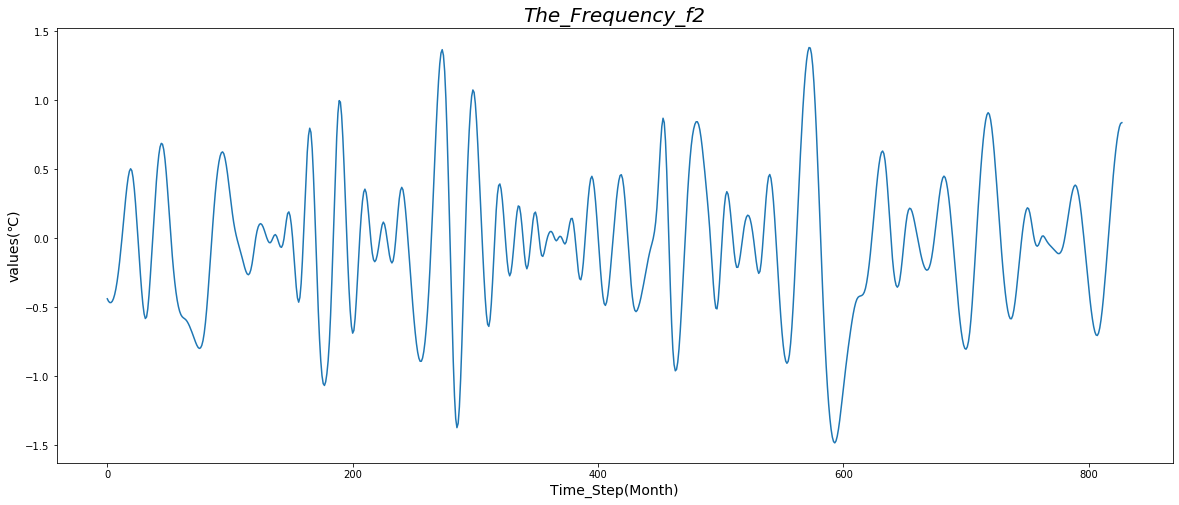

[[[0.0056482]
  [0.12307  ]
  [0.23839  ]
  [0.34909  ]
  [0.45314  ]
  [0.54868  ]
  [0.63381  ]
  [0.70665  ]
  [0.76531  ]
  [0.80793  ]
  [0.83261  ]
  [0.83806  ]]]
[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70665   0.76531   0.80793   0.83261   0.83806  ]
(792, 24, 1)
Epoch 1/200
 - 6s - loss: 0.2301
Epoch 2/200
 - 2s - loss: 0.2171
Epoch 3/200
 - 2s - loss: 0.2002
Epoch 4/200
 - 2s - loss: 0.1411
Epoch 5/200
 - 2s - loss: 0.1251
Epoch 6/200
 - 2s - loss: 0.1041
Epoch 7/200
 - 2s - loss: 0.0898
Epoch 8/200
 - 2s - loss: 0.0883
Epoch 9/200
 - 2s - loss: 0.0839
Epoch 10/200
 - 2s - loss: 0.0816
Epoch 11/200
 - 2s - loss: 0.0765
Epoch 12/200
 - 2s - loss: 0.0751
Epoch 13/200
 - 2s - loss: 0.0754
Epoch 14/200
 - 2s - loss: 0.0638
Epoch 15/200
 - 2s - loss: 0.0594
Epoch 16/200
 - 2s - loss: 0.0542
Epoch 17/200
 - 2s - loss: 0.0542
Epoch 18/200
 - 2s - loss: 0.0655
Epoch 19/200
 - 2s - loss: 0.0600
Epoch 20/200
 - 2s - loss: 0.0513
Epoch 21/200
 - 2s - loss

(67, 12)
(840,)


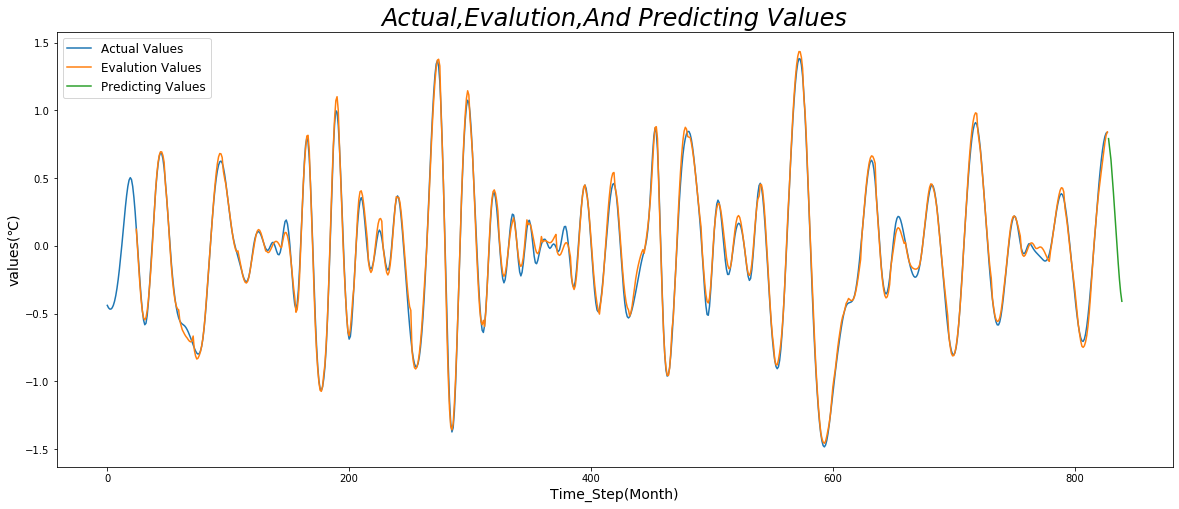

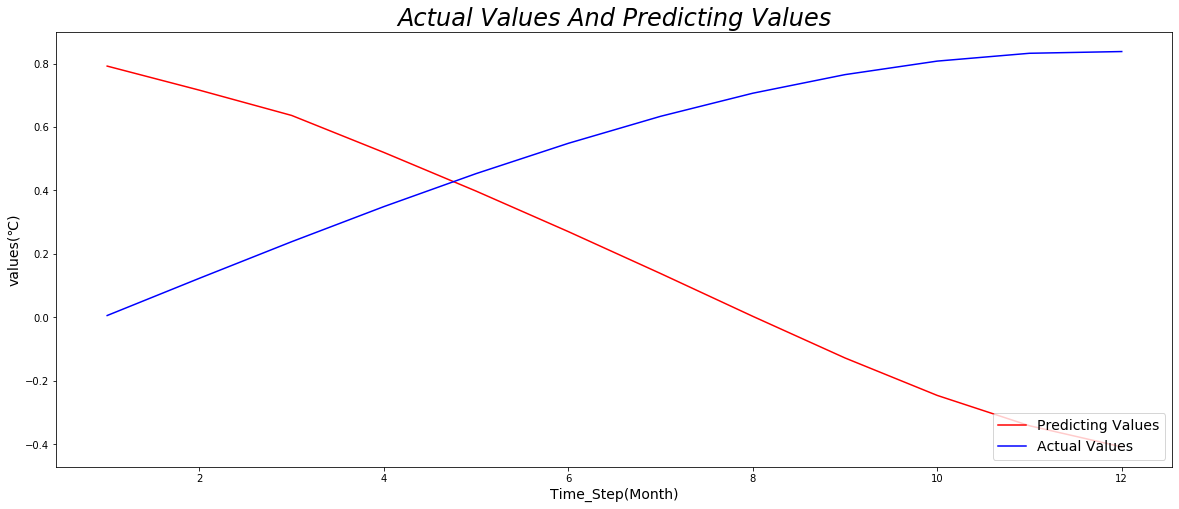

(828,)


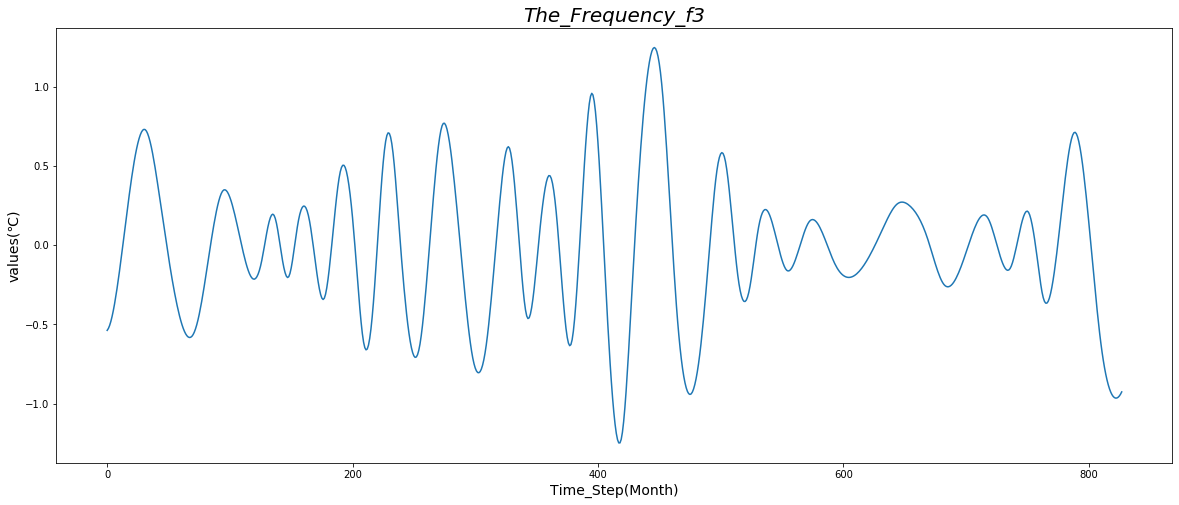

[[[-0.88131]
  [-0.90671]
  [-0.92735]
  [-0.94342]
  [-0.95507]
  [-0.96249]
  [-0.96584]
  [-0.96529]
  [-0.96101]
  [-0.95309]
  [-0.94162]
  [-0.92675]]]
[-0.88131 -0.90671 -0.92735 -0.94342 -0.95507 -0.96249 -0.96584 -0.96529
 -0.96101 -0.95309 -0.94162 -0.92675]
(792, 24, 1)
Epoch 1/200
 - 6s - loss: 0.1458
Epoch 2/200
 - 2s - loss: 0.1117
Epoch 3/200
 - 2s - loss: 0.0654
Epoch 4/200
 - 2s - loss: 0.0464
Epoch 5/200
 - 2s - loss: 0.0368
Epoch 6/200
 - 2s - loss: 0.0281
Epoch 7/200
 - 2s - loss: 0.0244
Epoch 8/200
 - 2s - loss: 0.0214
Epoch 9/200
 - 2s - loss: 0.0234
Epoch 10/200
 - 2s - loss: 0.0173
Epoch 11/200
 - 2s - loss: 0.0158
Epoch 12/200
 - 2s - loss: 0.0120
Epoch 13/200
 - 2s - loss: 0.0133
Epoch 14/200
 - 2s - loss: 0.0144
Epoch 15/200
 - 2s - loss: 0.0149
Epoch 16/200
 - 2s - loss: 0.0156
Epoch 17/200
 - 2s - loss: 0.0142
Epoch 18/200
 - 2s - loss: 0.0118
Epoch 19/200
 - 2s - loss: 0.0112
Epoch 20/200
 - 2s - loss: 0.0123
Epoch 21/200
 - 2s - loss: 0.0101
Epoch 22/200


(67, 12)
(840,)


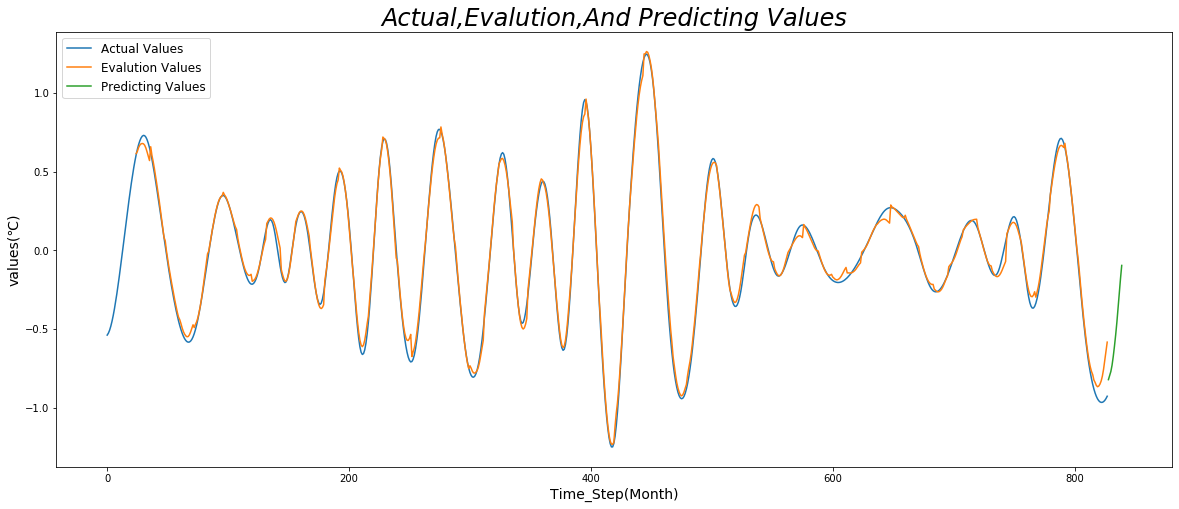

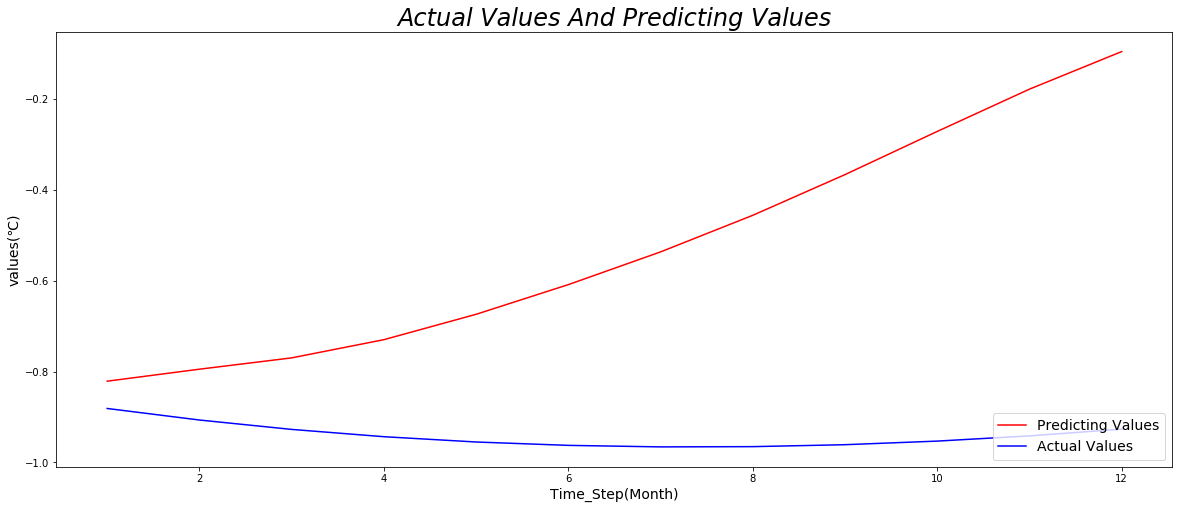

(828,)


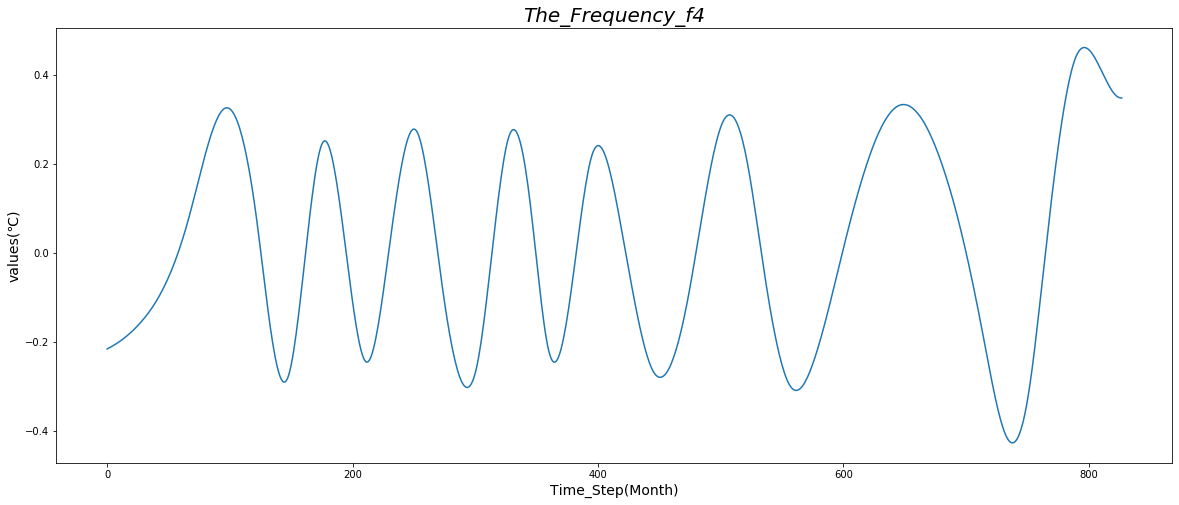

[[[0.37911]
  [0.37411]
  [0.36941]
  [0.36506]
  [0.36112]
  [0.35764]
  [0.35466]
  [0.35226]
  [0.35045]
  [0.34923]
  [0.34856]
  [0.34841]]]
[0.37911 0.37411 0.36941 0.36506 0.36112 0.35764 0.35466 0.35226 0.35045
 0.34923 0.34856 0.34841]
(792, 24, 1)
Epoch 1/200
 - 13s - loss: 0.0359
Epoch 2/200
 - 5s - loss: 0.0104
Epoch 3/200
 - 5s - loss: 0.0055
Epoch 4/200
 - 4s - loss: 0.0032
Epoch 5/200
 - 4s - loss: 0.0024
Epoch 6/200
 - 4s - loss: 0.0016
Epoch 7/200
 - 3s - loss: 0.0020
Epoch 8/200
 - 4s - loss: 0.0019
Epoch 9/200
 - 5s - loss: 9.0118e-04
Epoch 10/200
 - 6s - loss: 9.0958e-04
Epoch 11/200
 - 6s - loss: 9.7245e-04
Epoch 12/200
 - 5s - loss: 0.0012
Epoch 13/200
 - 4s - loss: 9.5019e-04
Epoch 14/200
 - 4s - loss: 7.4477e-04
Epoch 15/200
 - 3s - loss: 0.0013
Epoch 16/200
 - 3s - loss: 0.0013
Epoch 17/200
 - 4s - loss: 0.0017
Epoch 18/200
 - 3s - loss: 8.8348e-04
Epoch 19/200
 - 3s - loss: 0.0010
Epoch 20/200
 - 3s - loss: 8.5343e-04
Epoch 21/200
 - 3s - loss: 8.8654e-04
Epoc

(67, 12)
(840,)


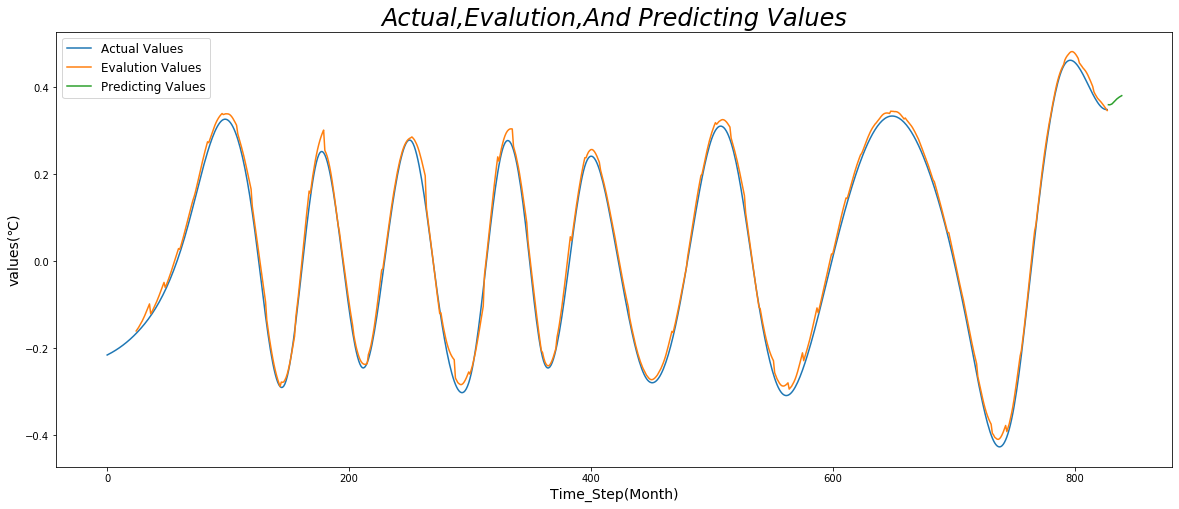

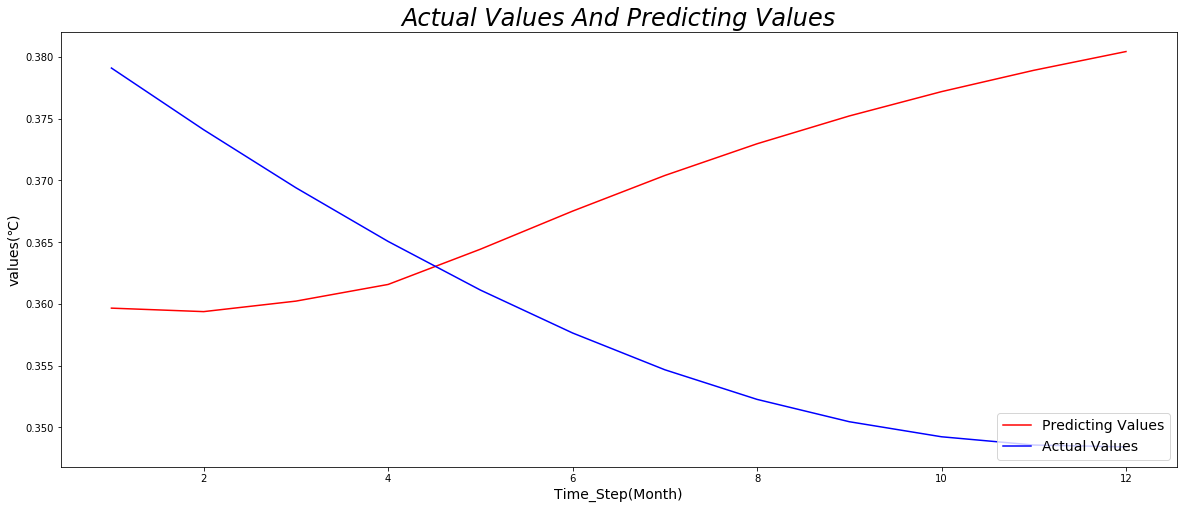

(828,)


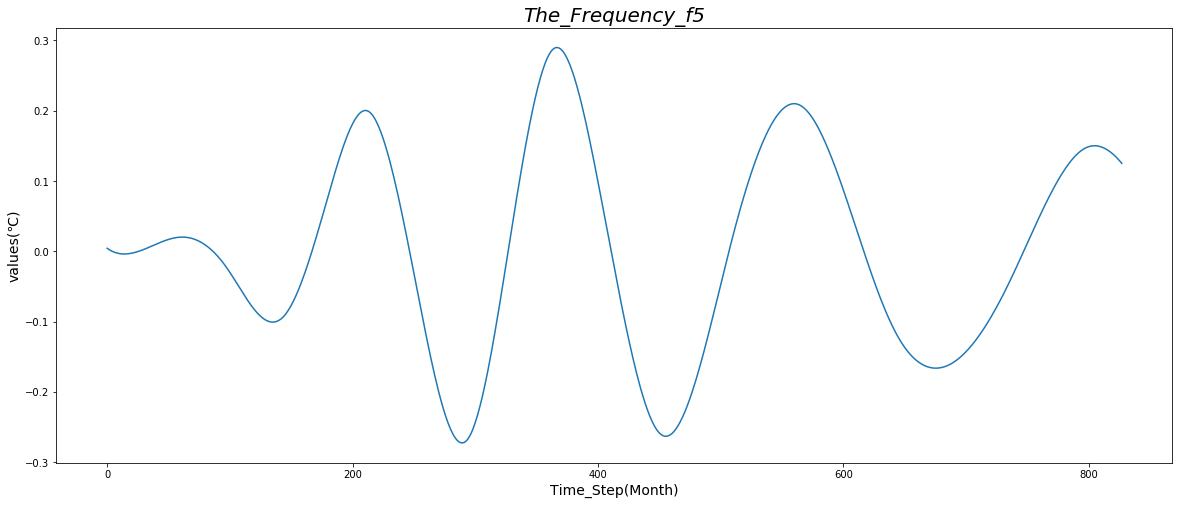

[[[0.1436 ]
  [0.14239]
  [0.14109]
  [0.13969]
  [0.1382 ]
  [0.13661]
  [0.13494]
  [0.13318]
  [0.13133]
  [0.1294 ]
  [0.12738]
  [0.12528]]]
[0.1436  0.14239 0.14109 0.13969 0.1382  0.13661 0.13494 0.13318 0.13133
 0.1294  0.12738 0.12528]
(792, 24, 1)
Epoch 1/200
 - 7s - loss: 0.0120
Epoch 2/200
 - 2s - loss: 0.0033
Epoch 3/200
 - 2s - loss: 8.4247e-04
Epoch 4/200
 - 2s - loss: 3.6188e-04
Epoch 5/200
 - 2s - loss: 1.5353e-04
Epoch 6/200
 - 2s - loss: 1.3066e-04
Epoch 7/200
 - 2s - loss: 1.0428e-04
Epoch 8/200
 - 2s - loss: 1.0902e-04
Epoch 9/200
 - 2s - loss: 9.3503e-05
Epoch 10/200
 - 2s - loss: 9.7411e-05
Epoch 11/200
 - 2s - loss: 8.1667e-05
Epoch 12/200
 - 2s - loss: 7.5188e-05
Epoch 13/200
 - 2s - loss: 5.9011e-05
Epoch 14/200
 - 2s - loss: 5.4613e-05
Epoch 15/200
 - 2s - loss: 5.8129e-05
Epoch 16/200
 - 2s - loss: 4.8649e-05
Epoch 17/200
 - 2s - loss: 6.7948e-05
Epoch 18/200
 - 2s - loss: 1.0952e-04
Epoch 19/200
 - 2s - loss: 5.4582e-05
Epoch 20/200
 - 2s - loss: 7.6308e-05

(67, 12)
(840,)


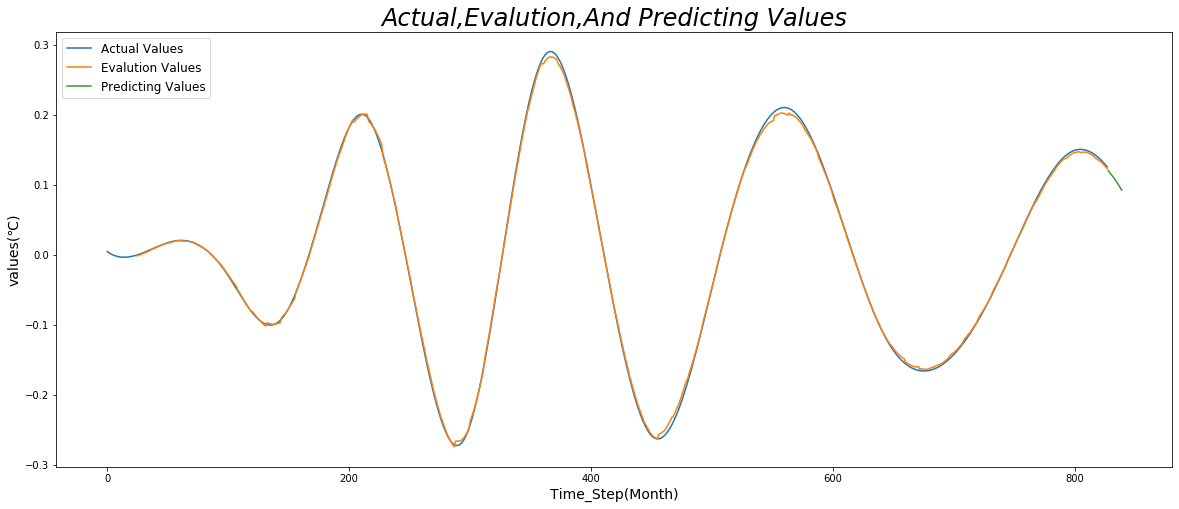

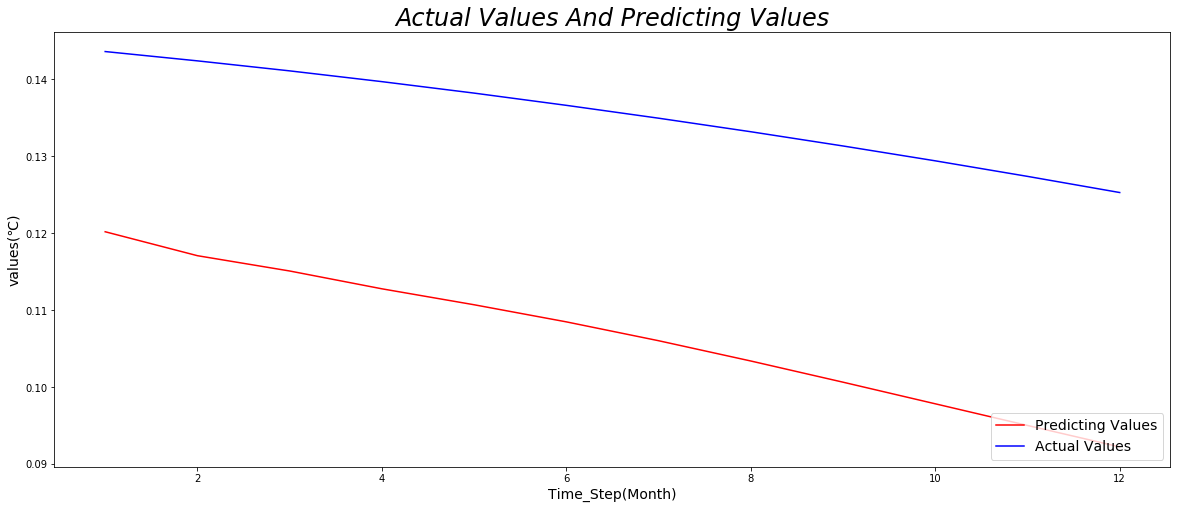

(828,)


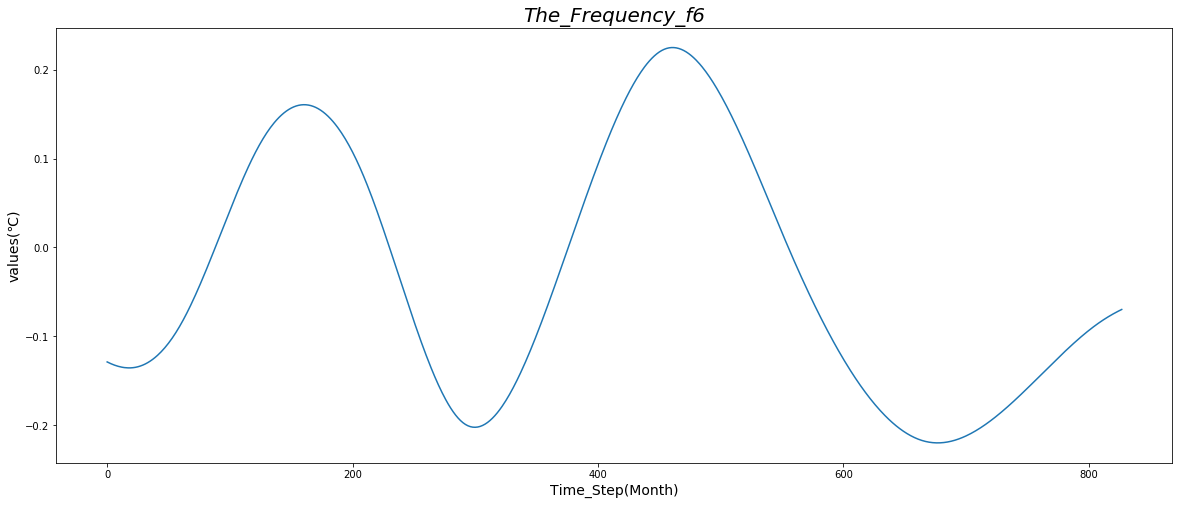

[[[-0.078087]
  [-0.077258]
  [-0.076445]
  [-0.075649]
  [-0.074869]
  [-0.074105]
  [-0.073357]
  [-0.072625]
  [-0.071909]
  [-0.071208]
  [-0.070523]
  [-0.069853]]]
[-0.078087 -0.077258 -0.076445 -0.075649 -0.074869 -0.074105 -0.073357
 -0.072625 -0.071909 -0.071208 -0.070523 -0.069853]
(792, 24, 1)
Epoch 1/200
 - 6s - loss: 0.0095
Epoch 2/200
 - 2s - loss: 0.0033
Epoch 3/200
 - 2s - loss: 0.0015
Epoch 4/200
 - 2s - loss: 4.5742e-04
Epoch 5/200
 - 2s - loss: 1.1997e-04
Epoch 6/200
 - 2s - loss: 6.0386e-05
Epoch 7/200
 - 2s - loss: 4.6384e-05
Epoch 8/200
 - 2s - loss: 3.9079e-05
Epoch 9/200
 - 2s - loss: 4.3396e-05
Epoch 10/200
 - 2s - loss: 3.4449e-05
Epoch 11/200
 - 2s - loss: 3.5456e-05
Epoch 12/200
 - 2s - loss: 3.3262e-05
Epoch 13/200
 - 2s - loss: 1.7890e-05
Epoch 14/200
 - 2s - loss: 1.8156e-05
Epoch 15/200
 - 2s - loss: 2.5328e-05
Epoch 16/200
 - 2s - loss: 2.0882e-05
Epoch 17/200
 - 2s - loss: 1.6976e-05
Epoch 18/200
 - 2s - loss: 2.2452e-05
Epoch 19/200
 - 2s - loss: 3.24

(67, 12)
(840,)


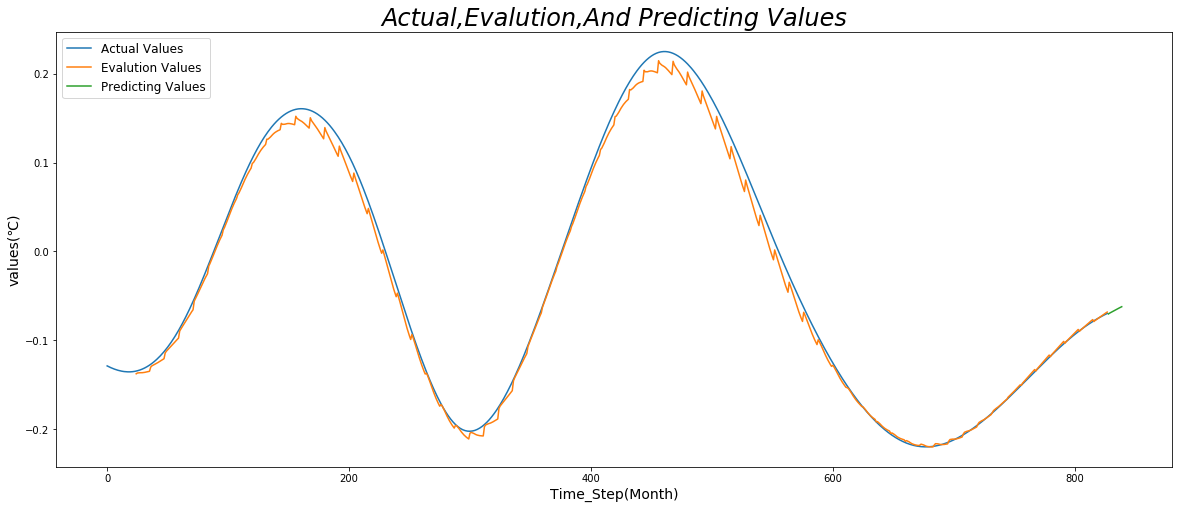

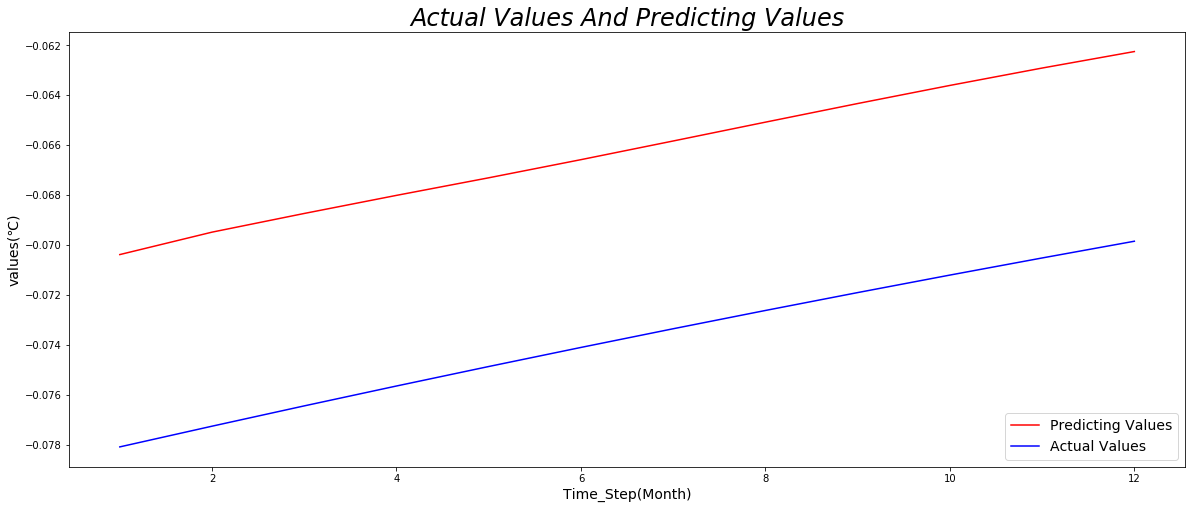

(828,)


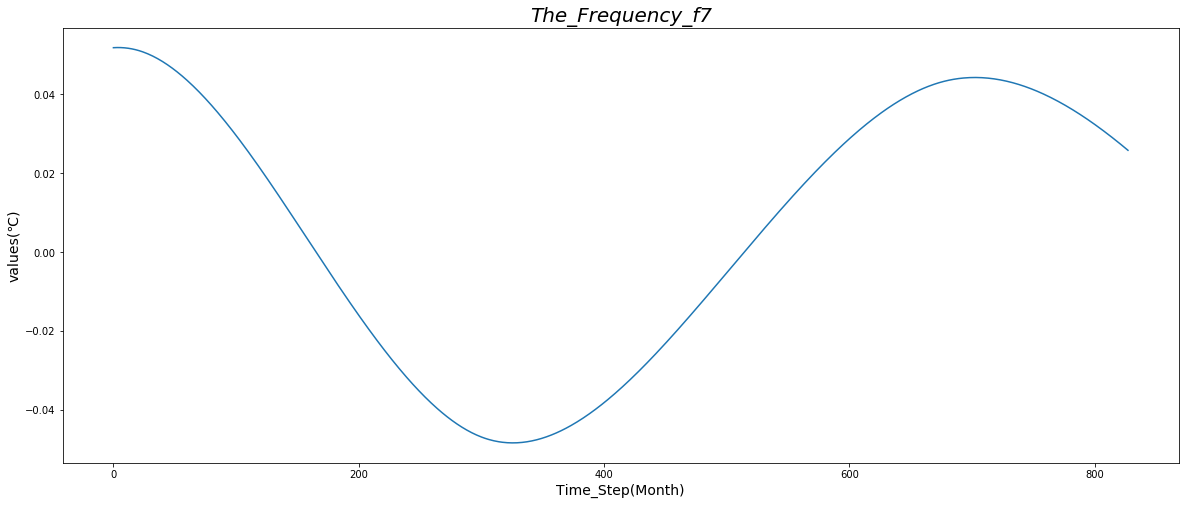

[[[0.02861 ]
  [0.028363]
  [0.028114]
  [0.027865]
  [0.027614]
  [0.027362]
  [0.027108]
  [0.026853]
  [0.026597]
  [0.026339]
  [0.026081]
  [0.025821]]]
[0.02861  0.028363 0.028114 0.027865 0.027614 0.027362 0.027108 0.026853
 0.026597 0.026339 0.026081 0.025821]
(792, 24, 1)
Epoch 1/200
 - 7s - loss: 8.0787e-04
Epoch 2/200
 - 2s - loss: 2.1212e-04
Epoch 3/200
 - 3s - loss: 1.2008e-04
Epoch 4/200
 - 5s - loss: 7.3798e-05
Epoch 5/200
 - 5s - loss: 5.3547e-05
Epoch 6/200
 - 4s - loss: 4.1442e-05
Epoch 7/200
 - 4s - loss: 3.1439e-05
Epoch 8/200
 - 4s - loss: 2.6755e-05
Epoch 9/200
 - 4s - loss: 2.7199e-05
Epoch 10/200
 - 4s - loss: 2.5682e-05
Epoch 11/200
 - 4s - loss: 2.6233e-05
Epoch 12/200
 - 4s - loss: 2.9752e-05
Epoch 13/200
 - 4s - loss: 2.8735e-05
Epoch 14/200
 - 4s - loss: 1.8958e-05
Epoch 15/200
 - 4s - loss: 1.6217e-05
Epoch 16/200
 - 4s - loss: 1.1426e-05
Epoch 17/200
 - 4s - loss: 1.4273e-05
Epoch 18/200
 - 3s - loss: 7.6342e-06
Epoch 19/200
 - 4s - loss: 4.3046e-06
Epoch

(67, 12)
(840,)


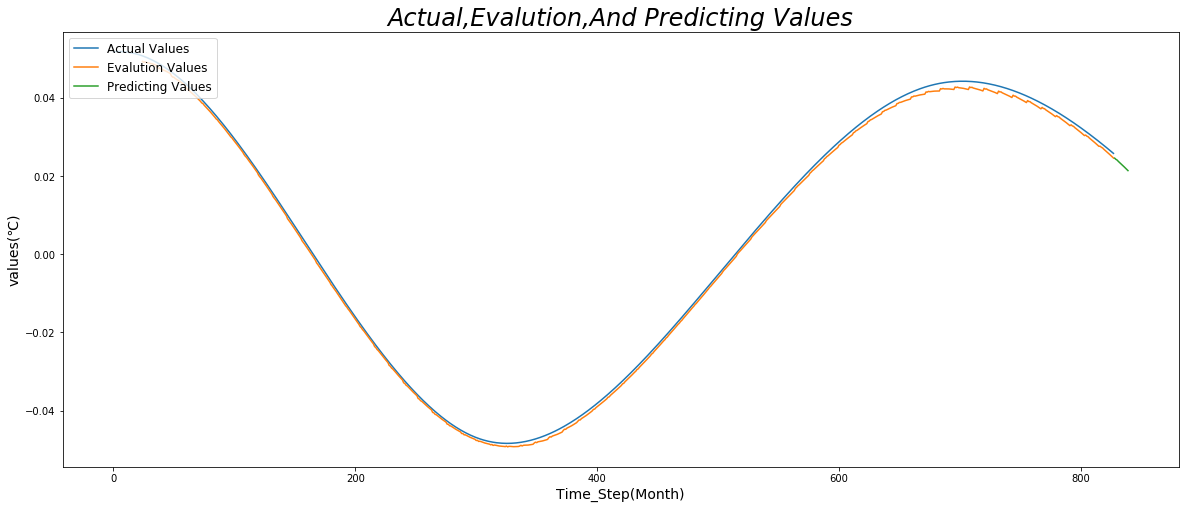

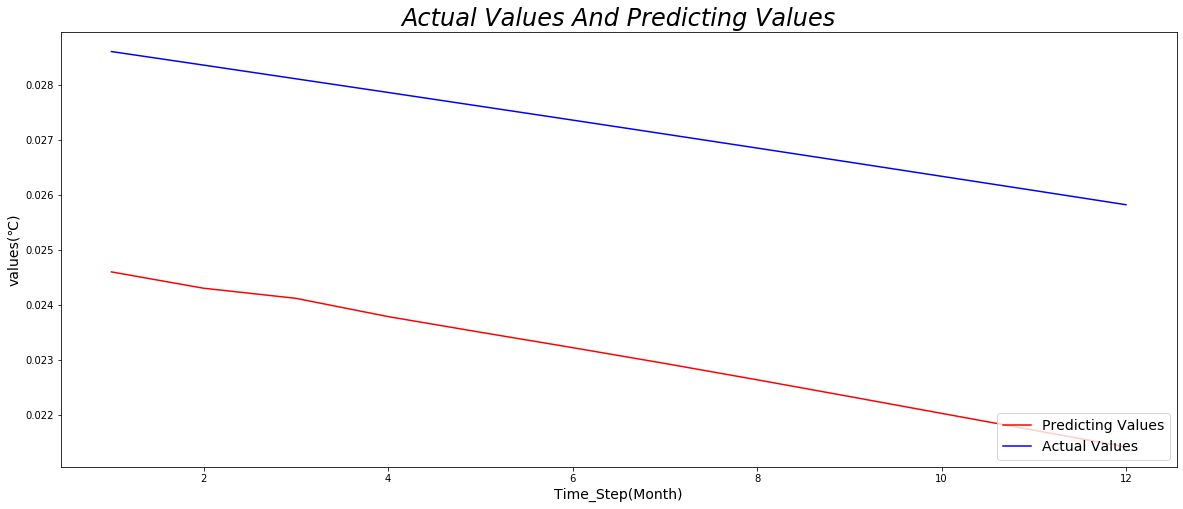

(828,)


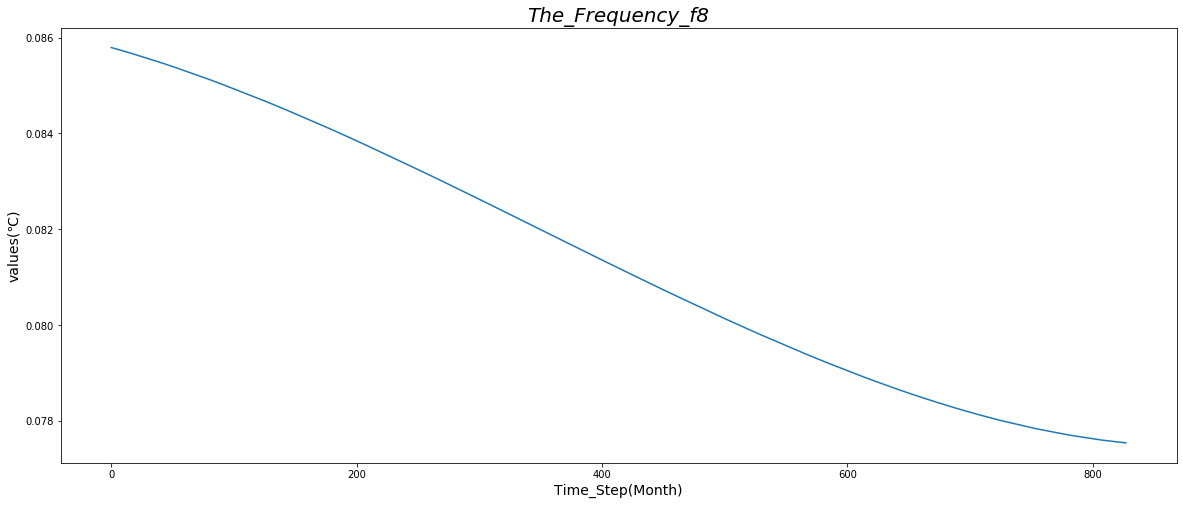

[[[0.077574]
  [0.077571]
  [0.077568]
  [0.077565]
  [0.077562]
  [0.077559]
  [0.077556]
  [0.077554]
  [0.077551]
  [0.077548]
  [0.077546]
  [0.077543]]]
[0.077574 0.077571 0.077568 0.077565 0.077562 0.077559 0.077556 0.077554
 0.077551 0.077548 0.077546 0.077543]
(792, 24, 1)
Epoch 1/200
 - 9s - loss: 4.9542e-04
Epoch 2/200
 - 3s - loss: 1.0087e-05
Epoch 3/200
 - 2s - loss: 6.8428e-06
Epoch 4/200
 - 2s - loss: 6.7705e-06
Epoch 5/200
 - 2s - loss: 6.7601e-06
Epoch 6/200
 - 2s - loss: 7.1132e-06
Epoch 7/200
 - 2s - loss: 7.6581e-06
Epoch 8/200
 - 2s - loss: 6.7615e-06
Epoch 9/200
 - 2s - loss: 7.1909e-06
Epoch 10/200
 - 2s - loss: 6.6379e-06
Epoch 11/200
 - 2s - loss: 6.7917e-06
Epoch 12/200
 - 2s - loss: 7.0087e-06
Epoch 13/200
 - 2s - loss: 6.9482e-06
Epoch 14/200
 - 2s - loss: 6.4959e-06
Epoch 15/200
 - 2s - loss: 6.8497e-06
Epoch 16/200
 - 2s - loss: 6.7152e-06
Epoch 17/200
 - 2s - loss: 7.7201e-06
Epoch 18/200
 - 2s - loss: 8.3868e-06
Epoch 19/200
 - 2s - loss: 8.1393e-06
Epoch

(67, 12)
(840,)


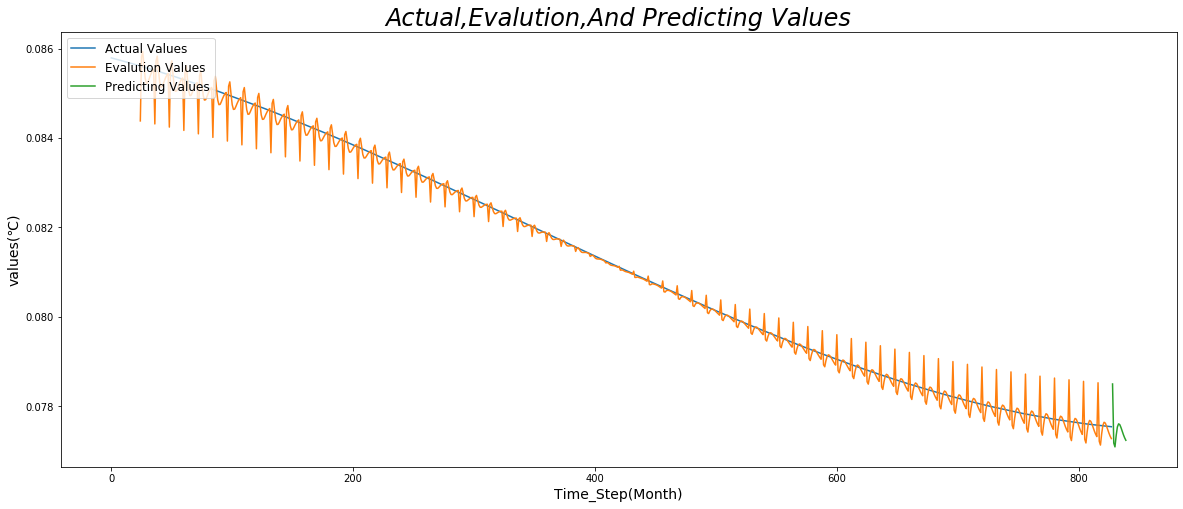

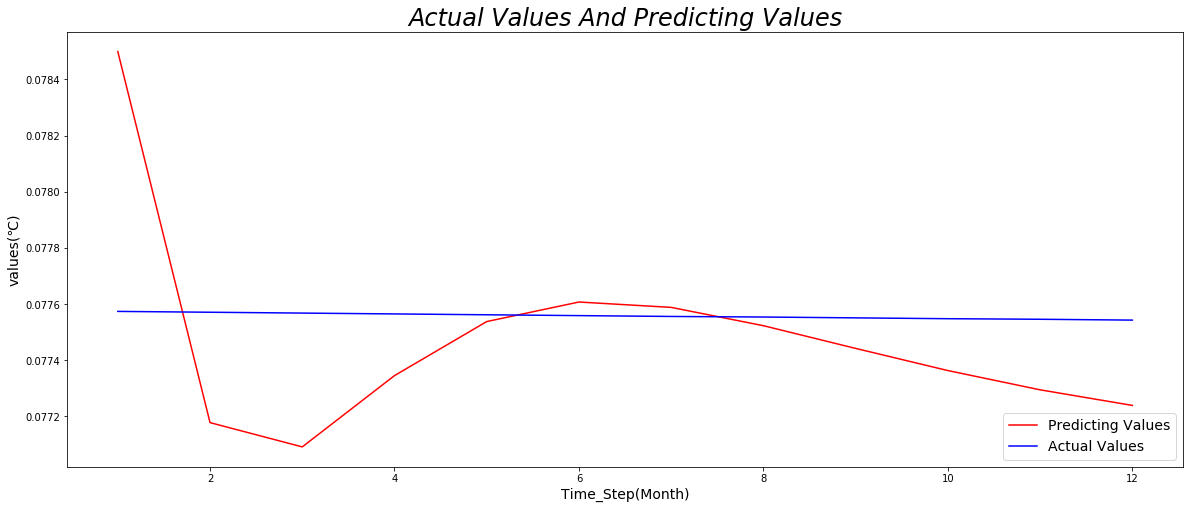

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD_2019')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD_2019')

for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][::]
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD_2019/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    print (test)
    print (test[0].reshape(-1))
    

    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    # it is changed for predicting 2019
    testPredictPlot = np.zeros(840)
    print (testPredictPlot.shape)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(testPredictPlot)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD_2019/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD_2019/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [7]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.07849894]
 [0.07717811]
 [0.07709172]
 [0.07734546]
 [0.07753782]
 [0.07760739]
 [0.0775883 ]
 [0.07752312]
 [0.07744228]
 [0.0773634 ]
 [0.07729487]
 [0.07723936]]
[array([-0.28373  , -0.20753  , -0.069358 ,  0.029479 ,  0.18765  ,
        0.20383  , -0.017003 , -0.14515  , -0.14641  ,  0.0092768,
        0.1346   ,  0.035037 ]), array([-0.29143 , -0.354   , -0.38141 , -0.36968 , -0.31534 , -0.21508 ,
       -0.071875,  0.086582,  0.22809 ,  0.32458 ,  0.36537 ,  0.34646 ]), array([0.0056482, 0.12307  , 0.23839  , 0.34909  , 0.45314  , 0.54868  ,
       0.63381  , 0.70665  , 0.76531  , 0.80793  , 0.83261  , 0.83806  ]), array([-0.88131, -0.90671, -0.92735, -0.94342, -0.95507, -0.96249,
       -0.96584, -0.96529, -0.96101, -0.95309, -0.94162, -0.92675]), array([0.37911, 0.37411, 0.36941, 0.36506, 0.36112, 0.35764, 0.35466,
       0.35226, 0.35045, 0.34923, 0.34856, 0.34841]), array([0.1436 , 0.14239, 0.14109, 0.13969, 0.1382 , 0.13661, 0.13494,
       0.13318, 0.13133, 0.1294 , 0.1

In [8]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
[[-0.28373  ]
 [-0.20753  ]
 [-0.069358 ]
 [ 0.029479 ]
 [ 0.18765  ]
 [ 0.20383  ]
 [-0.017003 ]
 [-0.14515  ]
 [-0.14641  ]
 [ 0.0092768]
 [ 0.1346   ]
 [ 0.035037 ]]
[[-0.28]
 [-0.21]
 [-0.07]
 [ 0.03]
 [ 0.19]
 [ 0.2 ]
 [-0.02]
 [-0.15]
 [-0.15]
 [ 0.01]
 [ 0.13]
 [ 0.04]]
-----------------------------------
observe value:[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
[[-0.57516  ]
 [-0.56153  ]
 [-0.450768 ]
 [-0.340201 ]
 [-0.12769  ]
 [-0.01125  ]
 [-0.088878 ]
 [-0.058568 ]
 [ 0.08168  ]
 [ 0.3338568]
 [ 0.49997  ]
 [ 0.381497 ]]
[[-0.58]
 [-0.56]
 [-0.45]
 [-0.34]
 [-0.13]
 [-0.01]
 [-0.09]
 [-0.06]
 [ 0.08]
 [ 0.33]
 [ 0.5 ]
 [ 0.38]]
-----------------------------------
observe value:[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70

In [9]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.02144249  0.03718299  0.08545708  0.03083231 -0.10784207 -0.1818649
 -0.11108156  0.03069386  0.10008821  0.04128051 -0.0465227  -0.06437898]
[-0.02144249  0.03718299  0.08545708  0.03083231 -0.10784207 -0.1818649
 -0.11108156  0.03069386  0.10008821  0.04128051 -0.0465227  -0.06437898]
the 1 frequence:
predicted_value:[ 0.26001883  0.20283195  0.14346051  0.05532403 -0.0625269  -0.18744071
 -0.28967232 -0.34153834 -0.32900932 -0.25738516 -0.14750616 -0.02549997]
[ 0.23857634  0.24001495  0.22891759  0.08615633 -0.17036898 -0.36930561
 -0.40075388 -0.31084448 -0.22892112 -0.21610465 -0.19402886 -0.08987894]
the 2 frequence:
predicted_value:[ 0.79218215  0.7162599   0.63656306  0.5199071   0.39796495  0.27022952
  0.13809934  0.00309497 -0.12824492 -0.24634434 -0.34193823 -0.40864122]
[ 1.03075849  0.95627484  0.86548065  0.60606345  0.22759598 -0.09907609
 -0.26265454 -0.30774951 -0.35716604 -0.462449   -0.53596

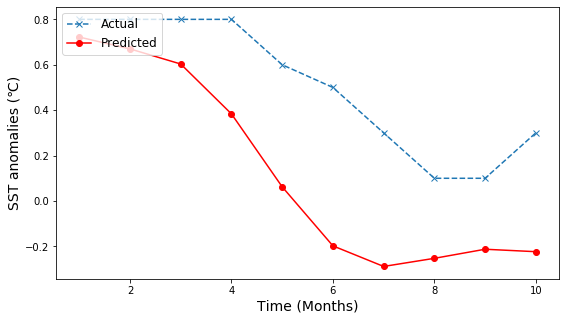

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np


actual_values_2019=[0.8,0.8,0.8,0.7,0.6,0.5,0.3,0.1,0.1,0.3,0.5,0.5]

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,np.array(actual_values_2019).reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,np.array(predicted_values).reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 
plt.show()